In [122]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import h5py
from scipy.spatial import KDTree, cKDTree
from lameg.surf import interpolate_data
from lameg.viz import show_surface, color_map
import io
from PIL import Image
from base64 import b64decode


In [170]:
plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

In [179]:
def add_subplot_label(ax, label, x=-.21, y=1.225, fontsize=26):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=fontsize, va='top', ha='right')


In [172]:
out_dir='./output/wb_simulations'
n_layers=11
win_size=50
snr=-20

In [173]:
# Mesh to use for forward model in the simulations
multilayer_mesh_fname = '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/multilayer.11.ds.link_vector.fixed.gii'

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

pial_orig_mesh = nib.load('/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/pial.gii')
pial_ds_mesh = nib.load('/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/pial.ds.gii')

multilayer_vertices = mesh.darrays[0].data
multilayer_faces = mesh.darrays[1].data  # Face indices
multilayer_orientations = mesh.darrays[2].data  # Assuming this is the orientation vectors

pial_vertices = pial_orig_mesh.darrays[0].data  # Vertex coordinates
pial_faces = pial_orig_mesh.darrays[1].data  # Face indices

pial_ds_vertices = pial_ds_mesh.darrays[0].data  # Vertex coordinates
pial_ds_faces = pial_ds_mesh.darrays[1].data  # Face indices

scalp_mesh=nib.load('/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/t1wscalp_2562.surf.gii')
scalp_vertices = scalp_mesh.darrays[1].data  # Vertex coordinates
scalp_faces = scalp_mesh.darrays[0].data  # Face indices

orig_inflated=nib.load('/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/inflated.gii')
ds_inflated=nib.load('/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/inflated.ds.gii')

In [174]:
# Compute surface normals (if not already available)
def compute_normals(vertices, faces):
    normals = np.zeros_like(vertices)
    for i in range(faces.shape[0]):
        v0, v1, v2 = vertices[faces[i]]
        # Edge vectors
        edge1 = v1 - v0
        edge2 = v2 - v0
        # Cross product to get normal
        normal = np.cross(edge1, edge2)
        normal /= np.linalg.norm(normal)  # Normalize the normal
        normals[faces[i]] += normal
    normals /= np.linalg.norm(normals, axis=1)[:, np.newaxis]  # Normalize all normals
    return normals

normals = compute_normals(scalp_vertices, scalp_faces)

 # Build a KD-tree for the downsampled vertices
tree = cKDTree(scalp_vertices) # pylint: disable=not-callable

# Find the nearest neighbor in the downsampled mesh for each vertex in the original mesh
distances, indices = tree.query(pial_ds_vertices)

# Compute the dot product between the orientation and the normal vectors
dot_products = np.abs(np.einsum('ij,ij->i', normals[indices], multilayer_orientations[:verts_per_surf,:])) 

In [175]:
left_side_view=[-150, -25, -28,
                8, 2.5, -32,
                0.25, -0.37, 0.9]

In [176]:
# Plot colors and camera view
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, dot_products)

c_range = [np.min(interpolated_data), np.max(interpolated_data)]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]


# Plot change in power on each surface
colors,_ = color_map(
    interpolated_data, 
    "Spectral_r", 
    0, 
    1,
    norm='N'
)
plot = show_surface(orig_inflated, vertex_colors=colors, info=True, camera_view=left_side_view)

Output()

317496 vertices


In [177]:
plot.fetch_screenshot()

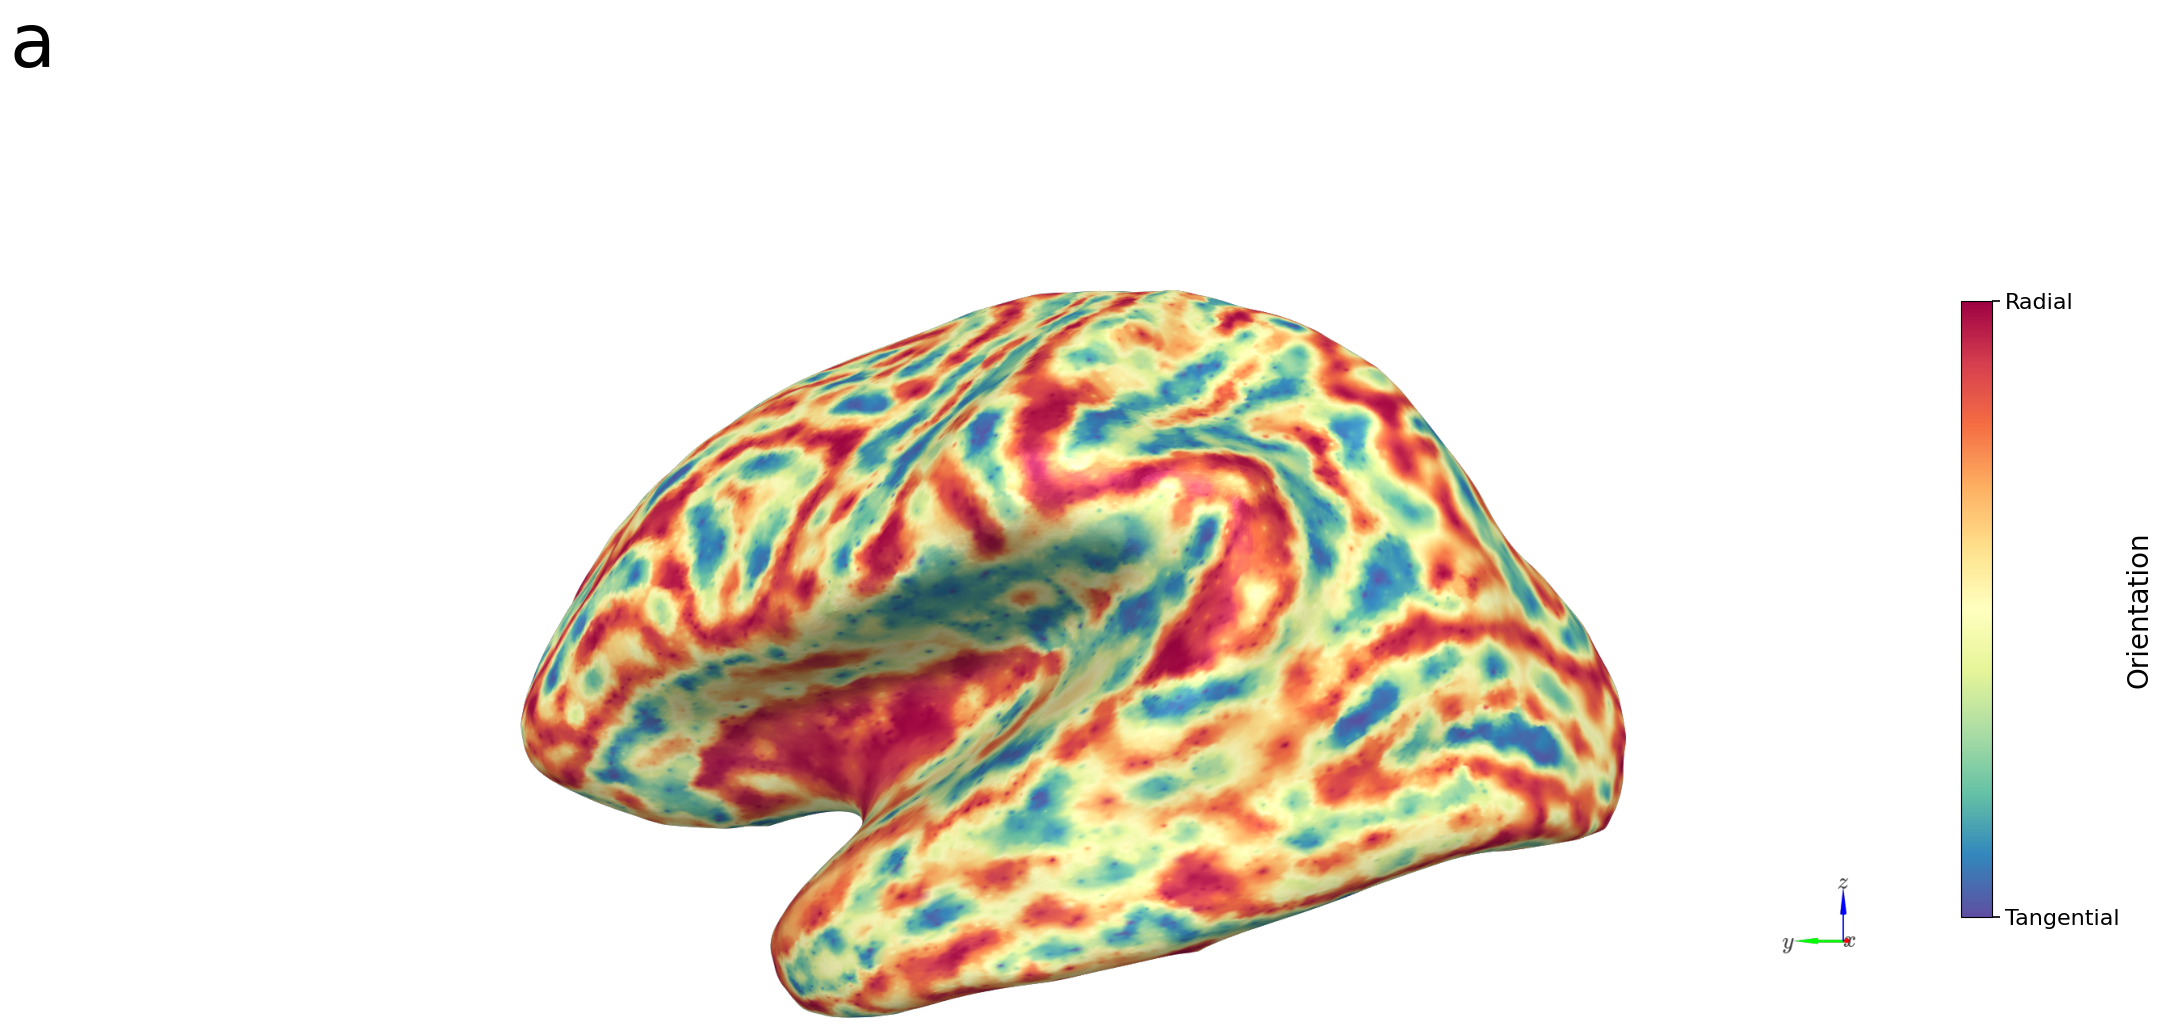

<Figure size 640x480 with 0 Axes>

In [181]:
# Decode the screenshot
image_data = b64decode(plot.screenshot)
image = Image.open(io.BytesIO(image_data))
image_array = np.array(image)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(24, 16))
ax.imshow(image_array)
ax.axis('off')  # Hide axes

# Create a ScalarMappable for the colorbar
vmin, vmax = np.min(interpolated_data), np.max(interpolated_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = cm.ScalarMappable(norm=norm, cmap="Spectral_r")

# Add colorbar
cbar = plt.colorbar(scalar_mappable, ax=ax, shrink=0.5, aspect=20, pad=0.02)
cbar.set_label("Orientation", fontsize=20)

# Set two ticks: at min (vmin) and max (vmax)
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(["Tangential", "Radial"])

add_subplot_label(ax, 'a', fontsize=54)

# Show and save figure
plt.show()
plt.savefig(f"figure_06_orientation.pdf")


In [182]:
# Plot colors and camera view
interpolated_data = interpolate_data(orig_inflated, ds_inflated, distances)
c_range = [np.percentile(interpolated_data,1), np.percentile(interpolated_data,99)]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot change in power on each surface
colors,_ = color_map(
    interpolated_data, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)
plot = show_surface(orig_inflated, vertex_colors=colors, info=True, camera_view=left_side_view)

Output()

317496 vertices


In [183]:
plot.fetch_screenshot()

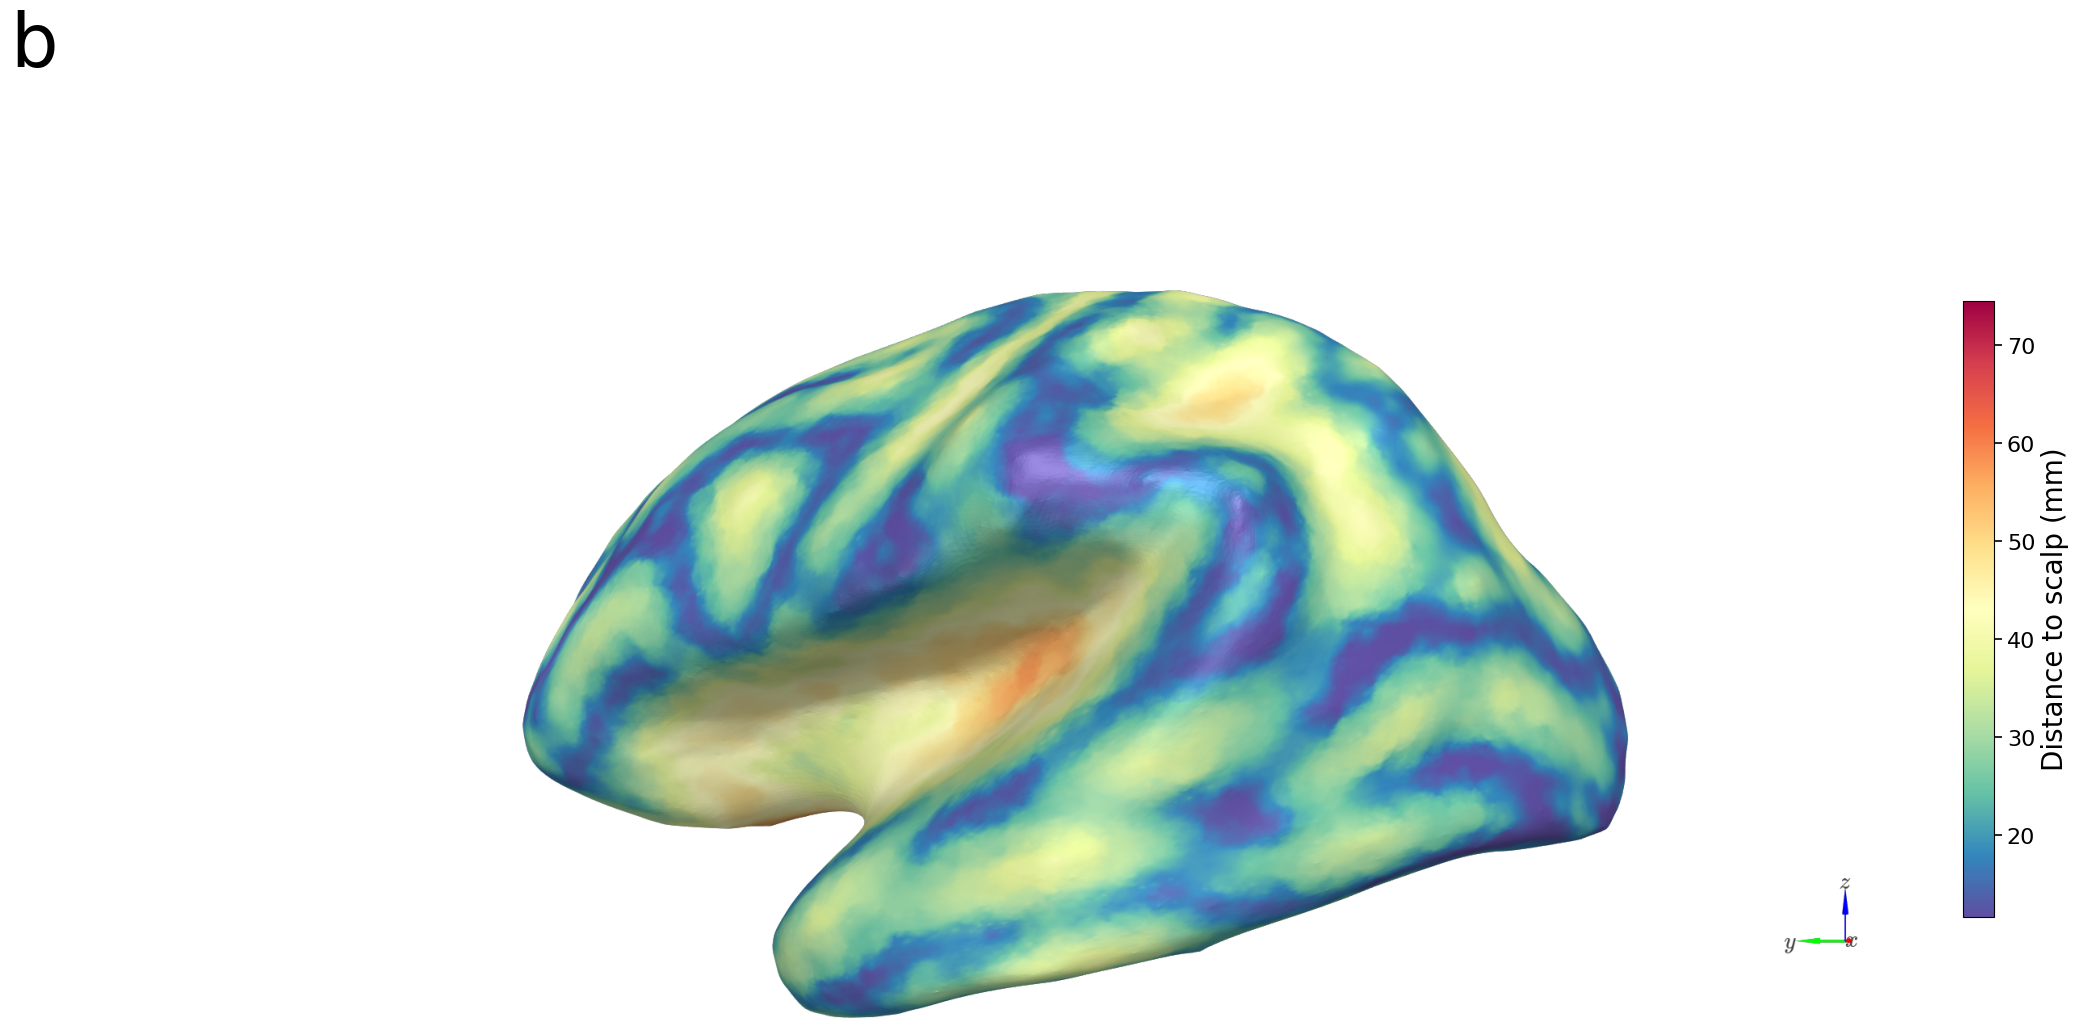

<Figure size 640x480 with 0 Axes>

In [184]:
# Decode the screenshot
image_data = b64decode(plot.screenshot)
image = Image.open(io.BytesIO(image_data))
image_array = np.array(image)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(24, 16))
ax.imshow(image_array)
ax.axis('off')  # Hide axes

# Create a ScalarMappable for the colorbar
vmin, vmax = np.min(interpolated_data), np.max(interpolated_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = cm.ScalarMappable(norm=norm, cmap="Spectral_r")

# Add colorbar
cbar = plt.colorbar(scalar_mappable, ax=ax, shrink=0.5, aspect=20, pad=0.02)
cbar.set_label("Distance to scalp (mm)", fontsize=20)

add_subplot_label(ax, 'b', fontsize=54)

# Show and save figure
plt.show()
plt.savefig(f"figure_06_distance.pdf")


In [185]:
gainmat='./output/wb_simulations/SPMgainmatrix_pcspm_converted_autoreject-sub-001-ses-01-motor-epo_1.mat'
with h5py.File(gainmat,'r') as file:
    lf_mat=file['G'][()]
lf_mat.shape

(320430, 275)

In [186]:
thickness=np.sqrt(np.sum((mesh.darrays[0].data[:verts_per_surf,:]-mesh.darrays[0].data[(n_layers-1)*verts_per_surf:,:])**2,axis=-1))

In [187]:
# Plot colors and camera view
interpolated_data = interpolate_data(orig_inflated, ds_inflated, thickness)
c_range = [np.percentile(interpolated_data,1), np.percentile(interpolated_data,99)]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot change in power on each surface
colors,_ = color_map(
    interpolated_data, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)
plot = show_surface(orig_inflated, vertex_colors=colors, info=True, camera_view=left_side_view)

Output()

317496 vertices


In [188]:
plot.fetch_screenshot()

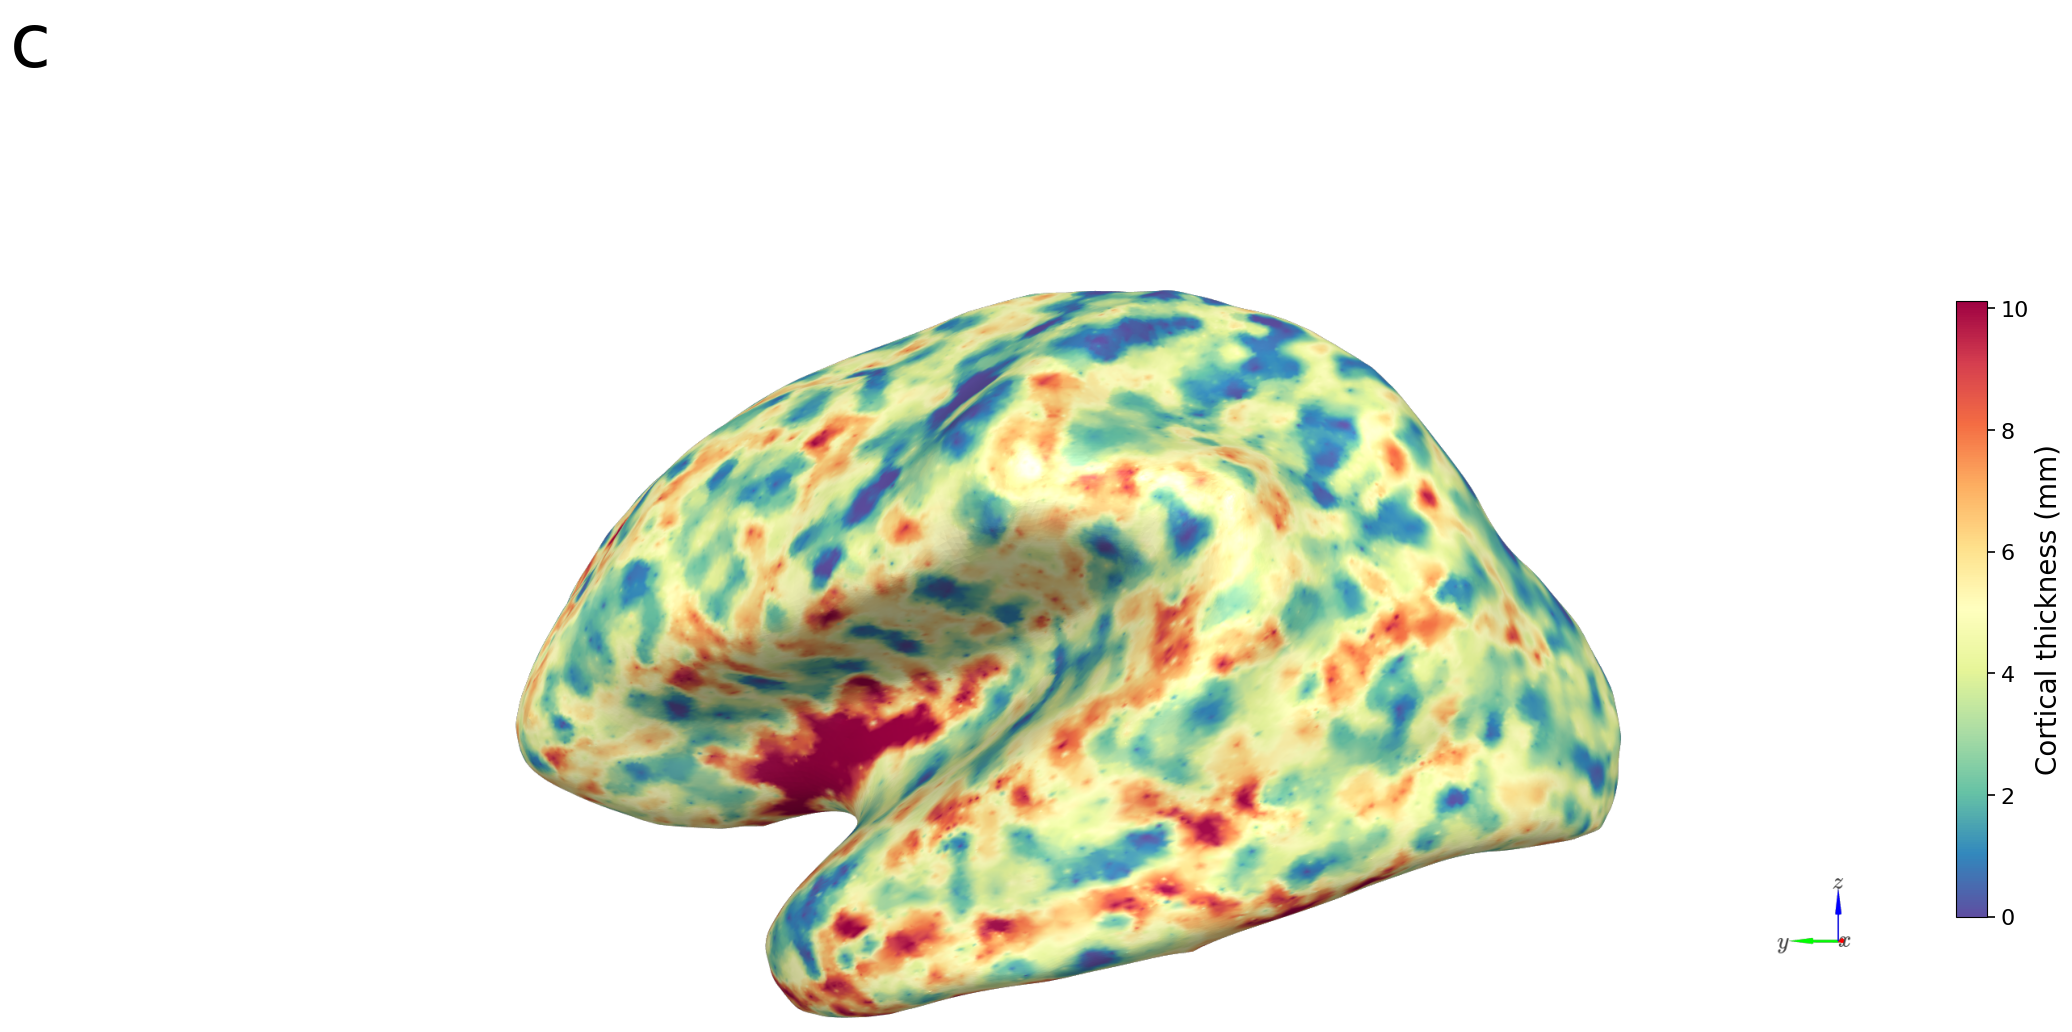

<Figure size 640x480 with 0 Axes>

In [191]:
# Decode the screenshot
image_data = b64decode(plot.screenshot)
image = Image.open(io.BytesIO(image_data))
image_array = np.array(image)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(24, 16))
ax.imshow(image_array)
ax.axis('off')  # Hide axes

# Create a ScalarMappable for the colorbar
vmin, vmax = np.min(interpolated_data), np.max(interpolated_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = cm.ScalarMappable(norm=norm, cmap="Spectral_r")

# Add colorbar
cbar = plt.colorbar(scalar_mappable, ax=ax, shrink=0.5, aspect=20, pad=0.02)
cbar.set_label("Cortical thickness (mm)", fontsize=20)

add_subplot_label(ax, 'c', fontsize=54)

# Show and save figure
plt.show()
plt.savefig(f"figure_06_thickness.pdf")


In [192]:
def compute_bias(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    n = matrix.shape[0]
    bias = np.zeros((n,1))
    
    # Loop through each column and check if the maximum value is on the diagonal
    for j in range(n):
        max_index = np.argmax(matrix[:, j])
        bias[j] = max_index-j 
    
    return np.mean(bias)


def compute_error(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    n = matrix.shape[0]
    error = np.zeros((n,1))
    
    # Loop through each column and check if the maximum value is on the diagonal
    for j in range(n):
        max_index = np.argmax(matrix[:, j])
        error[j] = np.abs(j-max_index)
    
    return np.mean(error)

In [193]:
v_idx=[]
bias_surf=[]
bias_mm=[]
error_surf=[]
error_mm=[]

fnames=sorted(glob.glob(os.path.join(out_dir, f'vx_*_snr_{snr}_winsize_{win_size}.pickle')))
for f_idx, fname in enumerate(fnames):
    with open(fname,'rb') as file:
        results=pickle.load(file)
    vertex=results['sim_vertex']
    norm_layerF = np.zeros((n_layers, n_layers))
    for l in range(n_layers):
        norm_layerF[:,l] = results['layerF'][:,l]-np.min(results['layerF'][:,l])                

    b = compute_bias(norm_layerF)
    e = compute_error(norm_layerF)
    v_idx.append(vertex)
    bias_surf.append(b)
    bias_mm.append(b*thickness[vertex])
    error_surf.append(e)
    error_mm.append(e*thickness[vertex])
v_idx=np.array(v_idx)
bias_surf=np.array(bias_surf)
bias_mm=np.array(bias_mm)
error_surf=np.array(error_surf)
error_mm=np.array(error_mm)

In [194]:
len(v_idx)

16252

In [195]:
layer_lf_mat=np.zeros((verts_per_surf, n_layers, lf_mat.shape[1]))
diff_layer_lf_mat=np.zeros((verts_per_surf, n_layers))
for i in range(n_layers):
    layer_lf_mat[:,i,:]=lf_mat[i*verts_per_surf:(i+1)*verts_per_surf,:]
for j in range(verts_per_surf):
    for i in range(n_layers):
        diff_layer_lf_mat[j,i]=np.sqrt(np.mean((layer_lf_mat[j,i,:]-layer_lf_mat[j,0,:])**2))

In [196]:
# Plot colors and camera view
interpolated_data = interpolate_data(orig_inflated, ds_inflated, diff_layer_lf_mat[:,-1])
c_range = [np.percentile(interpolated_data,1), np.percentile(interpolated_data,99)]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot change in power on each surface
colors,_ = color_map(
    interpolated_data, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)
plot = show_surface(orig_inflated, vertex_colors=colors, info=True, camera_view=left_side_view)

Output()

317496 vertices


In [197]:
plot.fetch_screenshot()

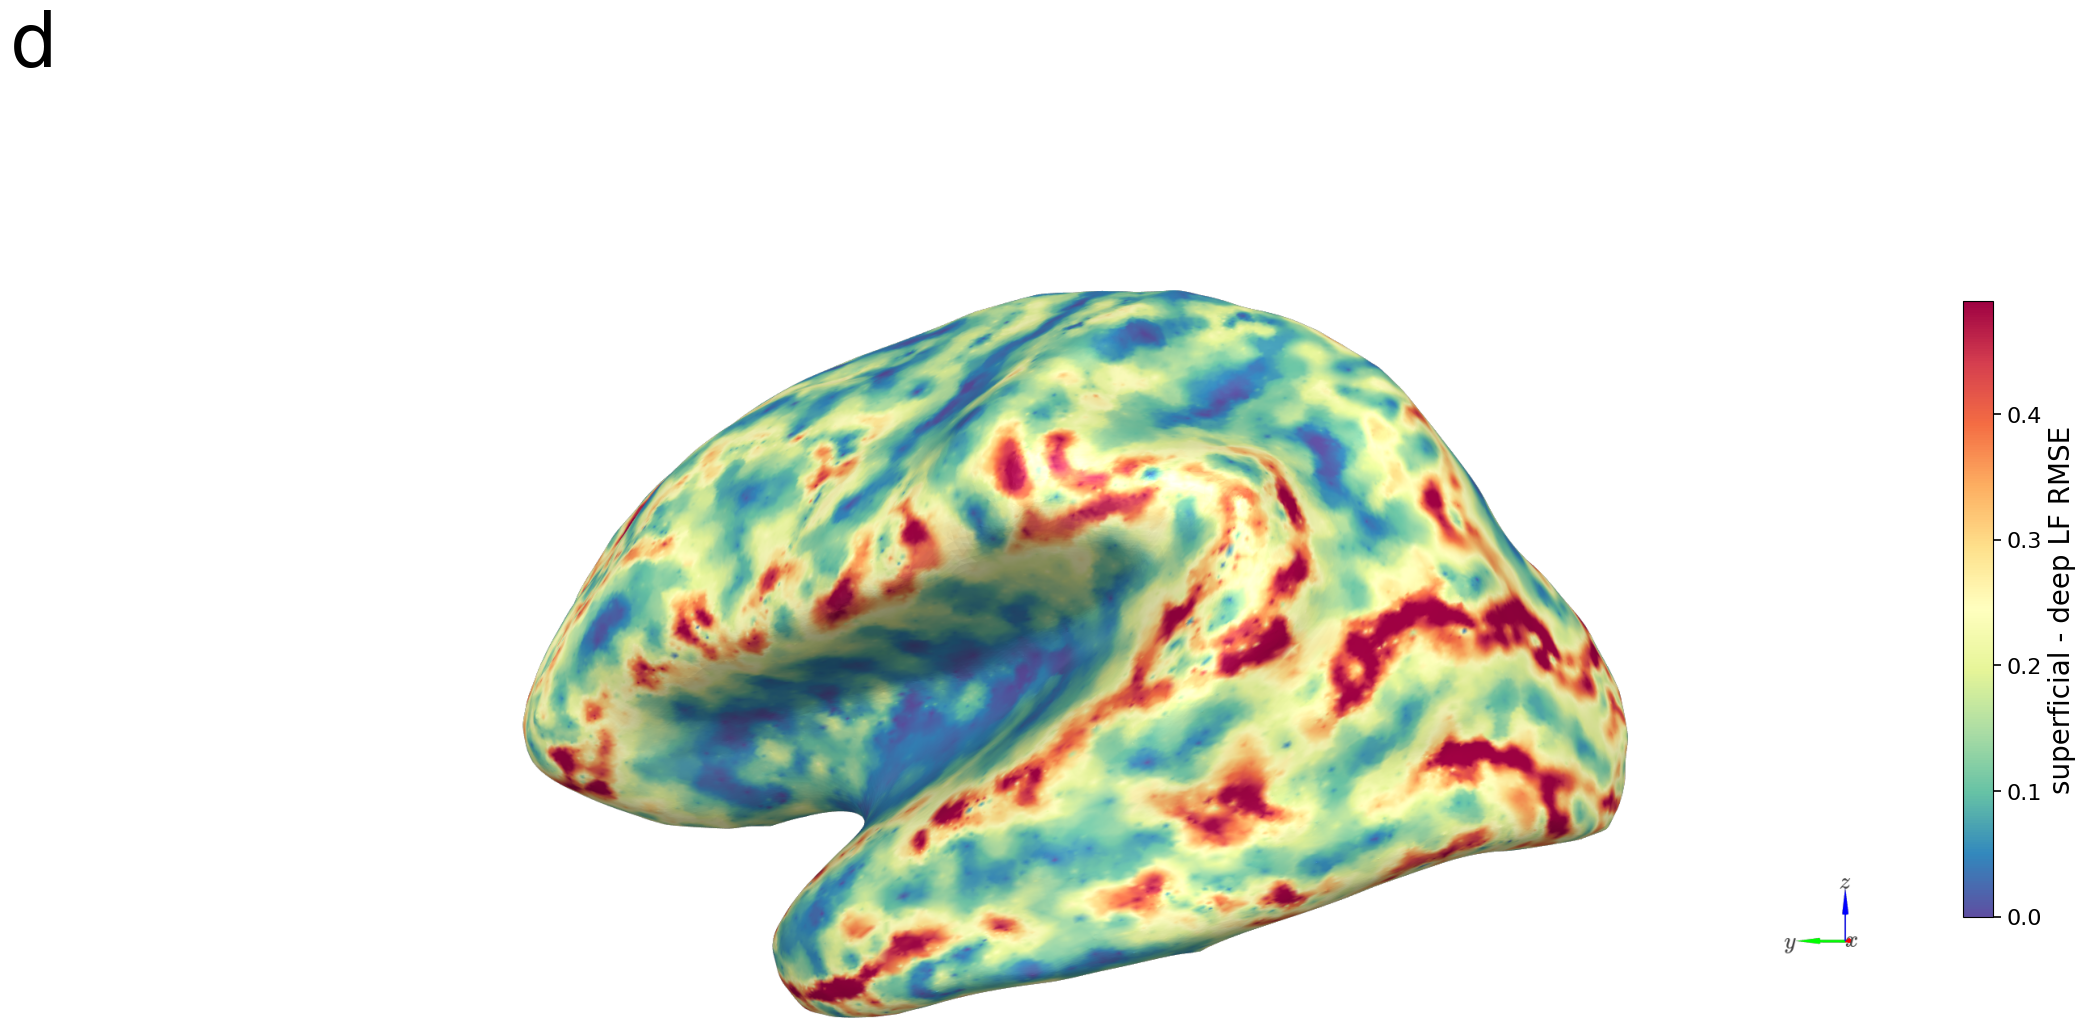

<Figure size 640x480 with 0 Axes>

In [199]:
# Decode the screenshot
image_data = b64decode(plot.screenshot)
image = Image.open(io.BytesIO(image_data))
image_array = np.array(image)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(24, 16))
ax.imshow(image_array)
ax.axis('off')  # Hide axes

# Create a ScalarMappable for the colorbar
vmin, vmax = np.min(interpolated_data), np.max(interpolated_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = cm.ScalarMappable(norm=norm, cmap="Spectral_r")

# Add colorbar
cbar = plt.colorbar(scalar_mappable, ax=ax, shrink=0.5, aspect=20, pad=0.02)
cbar.set_label("superficial - deep LF RMSE", fontsize=20)

add_subplot_label(ax, 'd', fontsize=54)

# Show and save figure
plt.show()
plt.savefig(f"figure_06_lead_field.pdf")

In [200]:
# Plot colors and camera view
error_all=np.zeros(verts_per_surf)
error_all[v_idx]=error_mm
interpolated_data = interpolate_data(orig_inflated, ds_inflated, error_all)
c_range = [0, np.percentile(interpolated_data,99.9)]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot change in power on each surface
colors,_ = color_map(
    interpolated_data, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)
plot = show_surface(orig_inflated, vertex_colors=colors, info=True, camera_view=left_side_view)

Output()

317496 vertices


In [201]:
plot.fetch_screenshot()

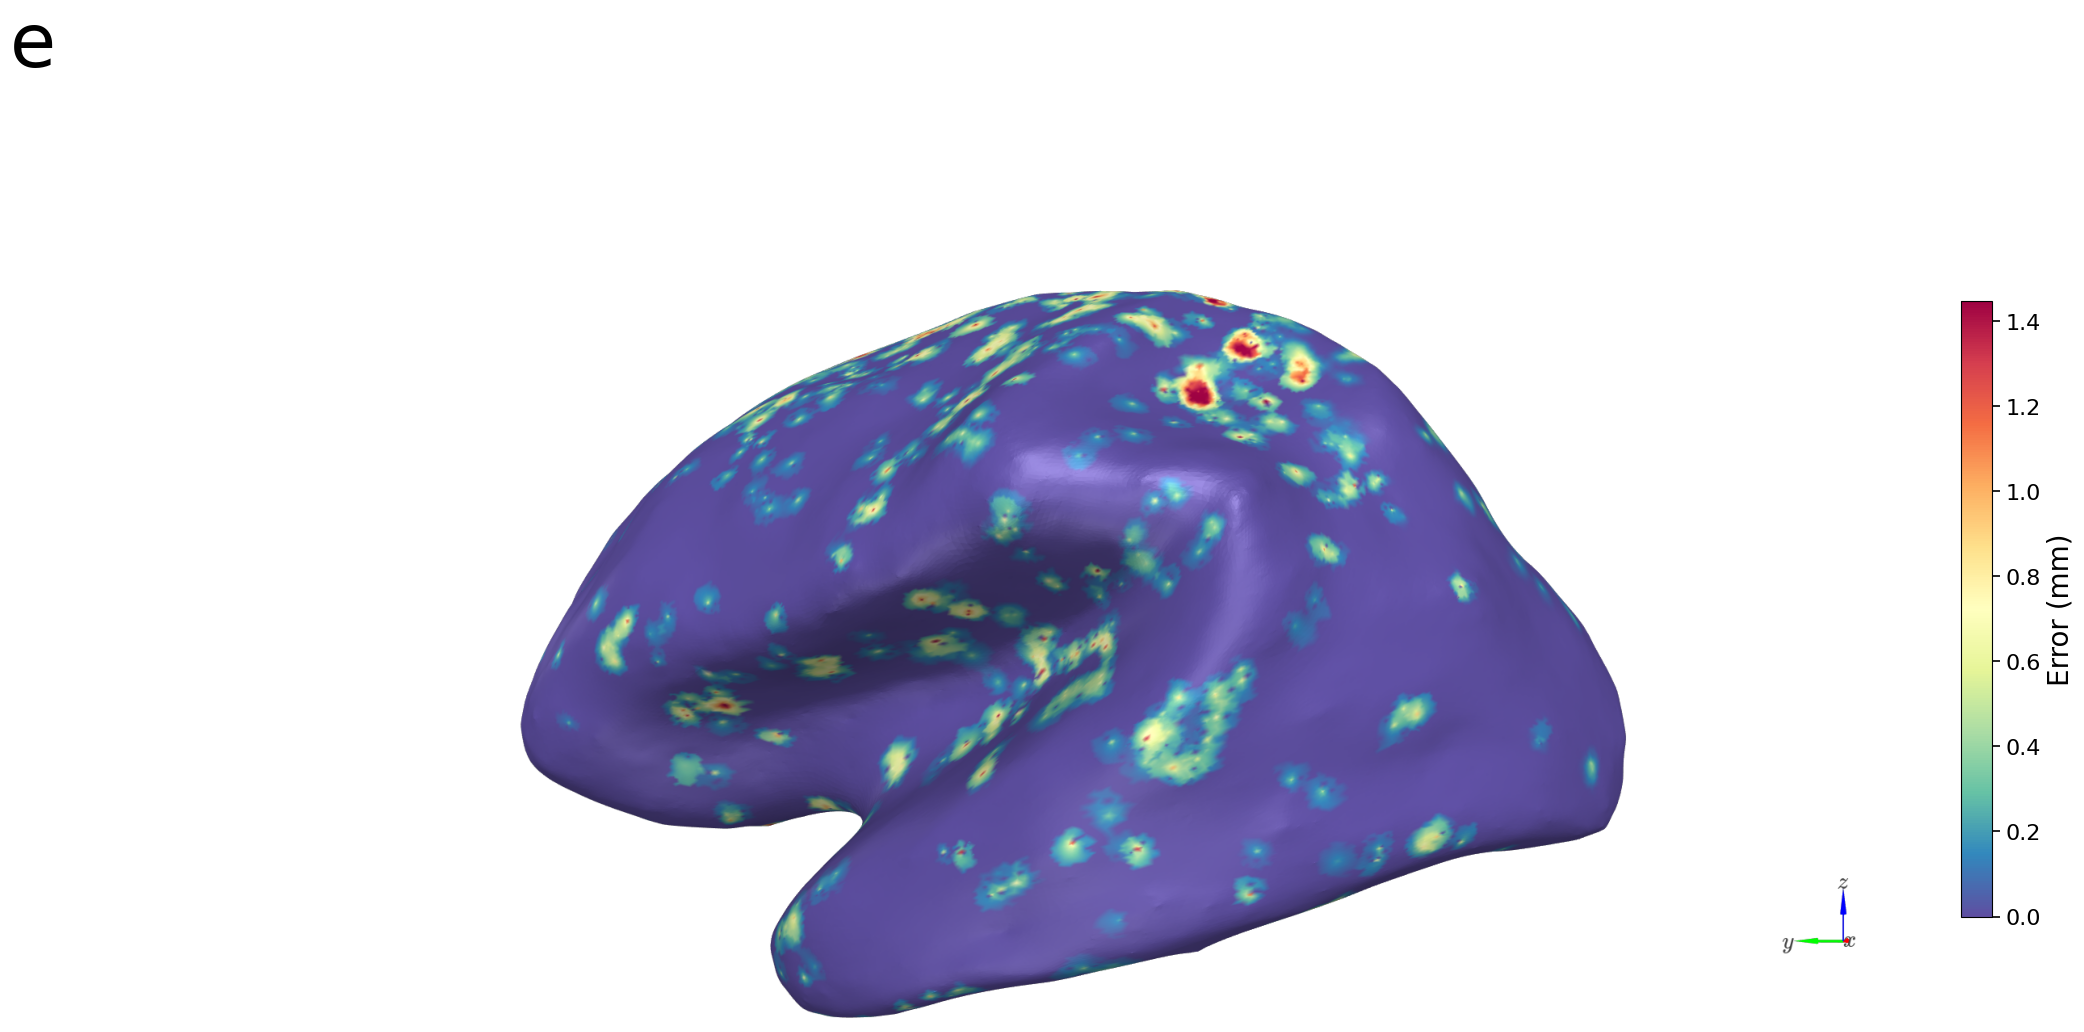

<Figure size 640x480 with 0 Axes>

In [203]:
# Decode the screenshot
image_data = b64decode(plot.screenshot)
image = Image.open(io.BytesIO(image_data))
image_array = np.array(image)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(24, 16))
ax.imshow(image_array)
ax.axis('off')  # Hide axes

# Create a ScalarMappable for the colorbar
vmin, vmax = np.min(interpolated_data), np.max(interpolated_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = cm.ScalarMappable(norm=norm, cmap="Spectral_r")

# Add colorbar
cbar = plt.colorbar(scalar_mappable, ax=ax, shrink=0.5, aspect=20, pad=0.02)
cbar.set_label("Error (mm)", fontsize=20)

add_subplot_label(ax, 'e', fontsize=54)

# Show and save figure
plt.show()
plt.savefig(f"figure_06_error_mm.pdf")

In [239]:
def plot_joint(x_vals, y_vals, error_mm, x_label, y_label, ax_label):
    # Example data (Replace with your actual data)
    x_blue = x_vals[error_mm == 0]  # Distance to scalp where error_mm == 0
    y_blue = y_vals[error_mm == 0]  # Lead Field RMSE where error_mm == 0

    x_red = x_vals[error_mm > 0]  # Distance to scalp where error_mm > 0
    y_red = y_vals[error_mm > 0]  # Lead Field RMSE where error_mm > 0

    # Create figure and scatter plot
    fig, ax_scatter = plt.subplots()
    ax_scatter.scatter(x_blue, y_blue, marker='.', c='b', alpha=0.1, label="error = 0")
    ax_scatter.scatter(x_red, y_red, marker='.', c='r', alpha=0.1, label="error > 0")
    ax_scatter.legend()

    ax_scatter.set_xlabel(x_label)
    ax_scatter.set_ylabel(y_label)

    # Create marginal histograms
    ax_histx = fig.add_axes([0.125, 0.9, 0.775, 0.2])  # X histogram (top)
    ax_histy = fig.add_axes([0.915, 0.11, 0.175, 0.775])  # Y histogram (right)

    ax_histx.hist(x_blue, bins=100, color='b', alpha=0.5, density=True)
    ax_histx.hist(x_red, bins=100, color='r', alpha=0.5, density=True)
    ax_histy.hist(y_blue, bins=100, color='b', alpha=0.5, density=True, orientation='horizontal')
    ax_histy.hist(y_red, bins=100, color='r', alpha=0.5, density=True, orientation='horizontal')

    # Hide tick labels on histograms
    ax_histx.set_xticks([])
    ax_histx.set_yticks([])
    ax_histx.set_ylabel('Density')
    ax_histy.set_xticks([])
    ax_histy.set_yticks([])
    ax_histy.set_xlabel('Density')

    for ax in [ax_scatter, ax_histx, ax_histy]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    add_subplot_label(ax_scatter, ax_label,x=-.15, y=1.3)

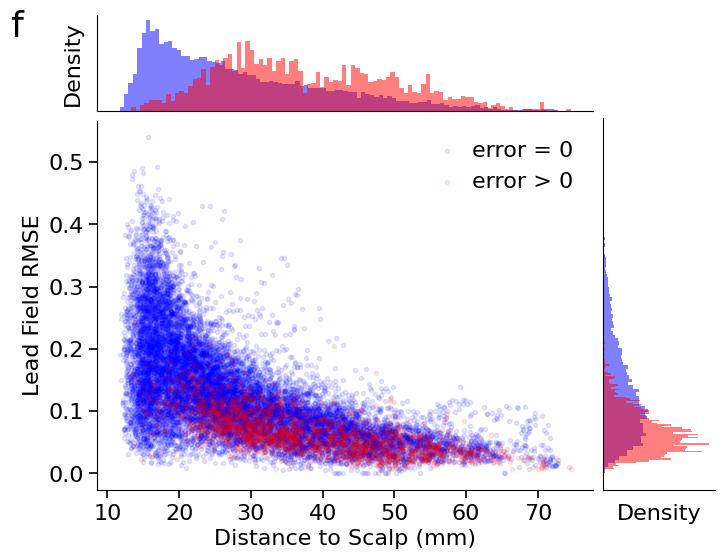

In [240]:
ax=plot_joint(distances[v_idx], diff_layer_lf_mat[v_idx,-1], error_mm, 'Distance to Scalp (mm)', 'Lead Field RMSE','f')

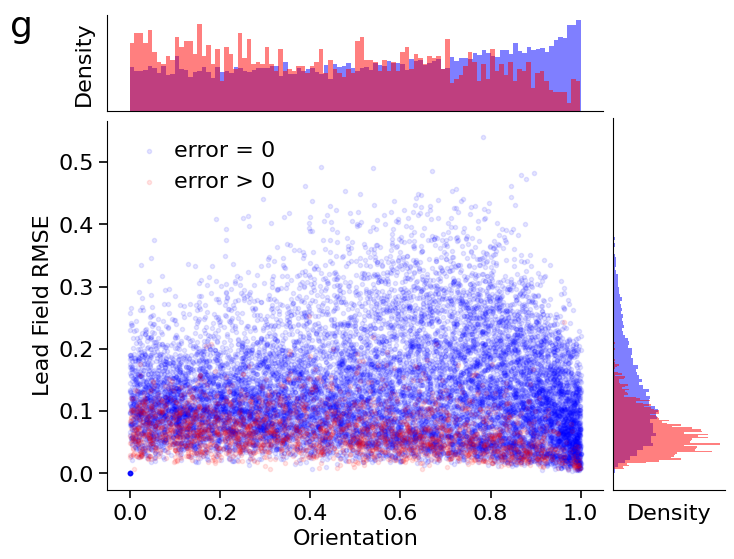

In [241]:
plot_joint(dot_products[v_idx], diff_layer_lf_mat[v_idx,-1], error_mm, 'Orientation', 'Lead Field RMSE','g')

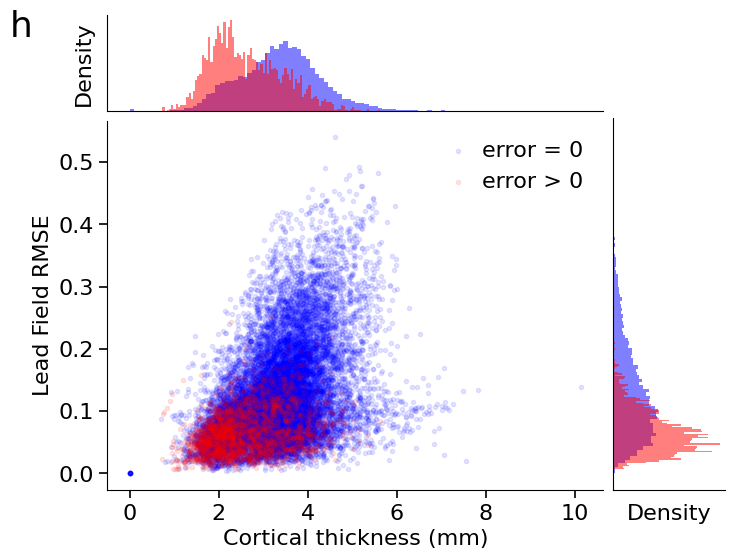

In [242]:
plot_joint(thickness[v_idx], diff_layer_lf_mat[v_idx,-1], error_mm, 'Cortical thickness (mm)', 'Lead Field RMSE','h')